# Bacterial growth, linear approximation

In [1]:
import  math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def Lt(t, T, l_0):
    """
    height of the colony in the microchannel
    as a functio of time
    """
    
    l = l_0*(1+ t/T - math.floor(t/T))
    n = 2**math.floor(t/T)
    
    return n, l, n*l

In [15]:
def plot_data():
    
    n_T = 3
    l_0=1
    T = 20

    t_steps  = [t for  t in range(0, n_T*T)] # 3 periods of T  timesteps
    length = [Lt(t, T, l_0)[2] for t in t_steps]
    plt.figure(figsize=(8,6))
    plt.title('length of the colony in the channel as a function of time for %i periods, %i points each period' %(n_T, T))
    plt.xlabel('timesteps')
    plt.ylabel('colony length, units')
    plt.scatter(t_steps, length,  )
    plt.grid()        

Assuming linear growth of the cell we can  get the lenght of the colony as a  function  of time:

$$L(t)  = 2^{\lfloor t/T \rfloor }l_0(1 +  t/T - \lfloor t/T \rfloor), $$
where $l_0$ -- initial length of the  cell, $T$ -- replication  period, $\lfloor x \rfloor$ -- the floor function.

The graph of the process looks  like:

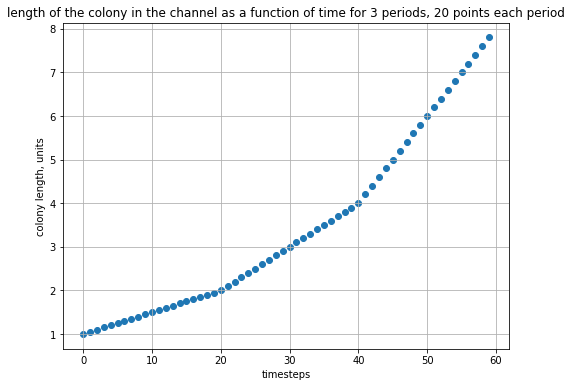

In [16]:
plot_data()

The length of the colony doubles each replication  period.
As one can see,  the slope of the length curve is  linear between replications, and the slope of  the curve  grows as $2^{\lfloor t/T \rfloor}$.

# An ensemble of channels


In each of the channel, the initial lenght  of the  cell, $l_0$, is a  bit different (mimicking biodiversity), sampled from the normal distribution,  e.g. $N(\mu=1.0, \sigma=0.05)$.

Also  we select  and  _fix_  during the experiment the length of each channel,  $L_{max}$.  As soon as the length of the  colony exceeds $L_{max}$, the  cells being pushed out and flow away (mimicking the lab experiment). 

We observe  how the lengths  of the  cells change as a function of time within one replication period.  

In [5]:
def get_distr_l_0(l_0, k, T):
    """
    returns list of tuples of (n_cell, cell_length)  for a given L_max and l0
    """
    lst =[]
    for t in range(k*T, (k+1)*T):
        n, l, total_length = Lt(t, T, l_0)
        n_L_max  = int(L_max/total_length*n)
#         print(t, n, l, n_L_max)
        lst.append((l, n_L_max))
    return lst

In [6]:
def  run(mu=1.0, sigma=.05, n_channels=100):
    """
    run the experiment
    returns the lists of cell sizes and cell numbers
    """
    global_lst = []
    for l_0 in np.random.normal(mu, sigma, n_channels):
        k = int(math.log2(L_max/l_0)) +1
        global_lst.append(get_distr_l_0(l_0, k, T))  
        
    flatten_global = [el for sub in global_lst for el in sub]
    x, y = zip(*flatten_global)
    
    return x,y

# Running the experiment

In [17]:
T = 20 # number of timesteps  per period
L_max = 1500 # channel length, units
mu=1.0  # mean of the  initial cell length
sigma=0.02 # std  dev of initila cell length
n_channels = 2500 # number of  channels


After conducting experiment  for ensemble of channels during one replication period we plot the histogram  for observed cell lengths and  number of cells.

Cell length $l=1$ corresponds to the initial  mean value of $l_0=1.0$, the $l=2.0$ corresponds to the mean cell size right before dividing moment.


In [27]:
def plot_hists(n_channels=n_channels, mu=mu, sigma=sigma, L_max=L_max):
    
    x, y = run(mu=mu, sigma=sigma, n_channels=n_channels)
    
    plt.figure(figsize=(16,8))
    plt.suptitle('Distributions for ensemble of %i channels, $\\forall l_0 \in N(\mu=%1.1f, \sigma=%1.3f)$'
                 %(n_channels,mu,sigma), fontsize=16)
    plt.subplot(1,2,1)
    plt.hist(x, bins=50, hatch='.', edgecolor='black')
    plt.title('cell length distribution ')
    plt.xlabel('cell length,  $l$,  units')
    plt.grid()

    plt.subplot(1,2,2)
    plt.hist(y, bins=50, hatch='\\', edgecolor='black', color='red')
    plt.title('number of  cells  distribution within channel of length $L_{max}=$%i'%(L_max))
    plt.xlabel('number of cell')
    plt.grid()

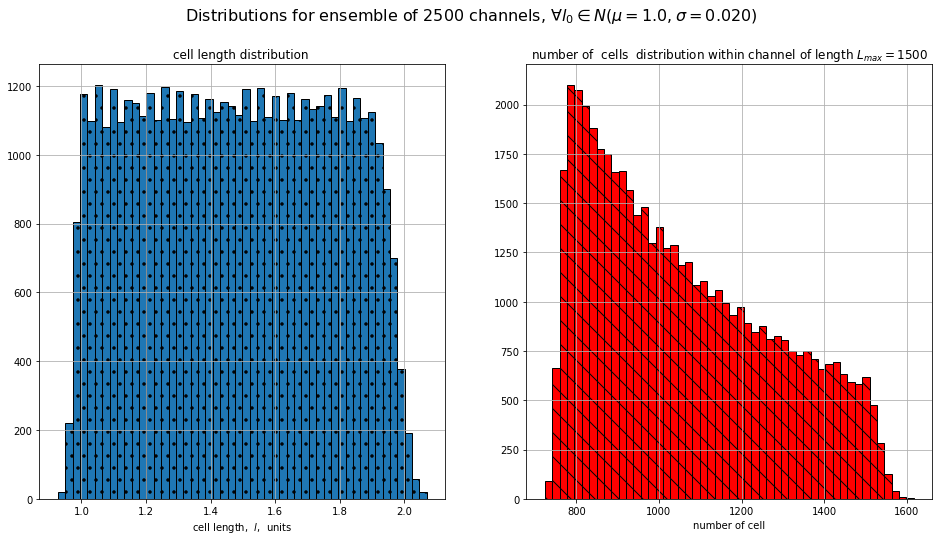

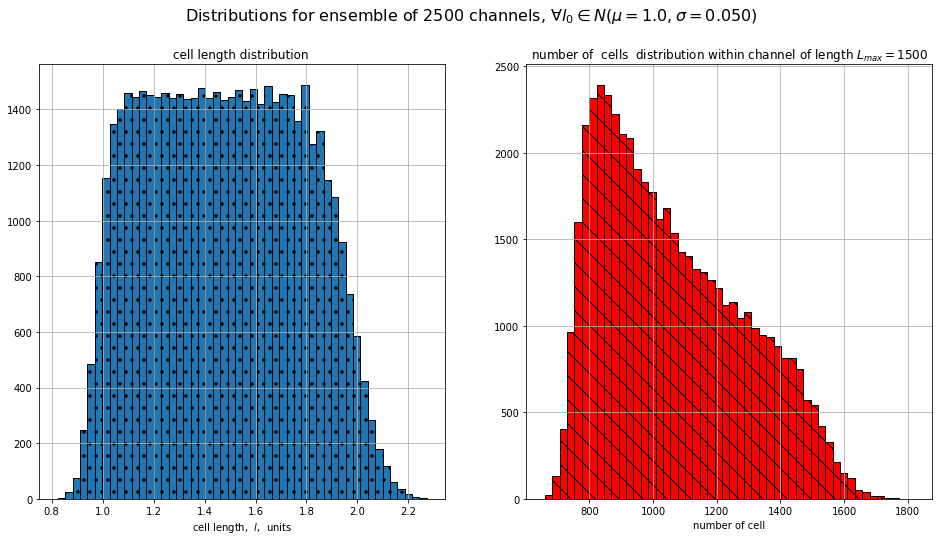

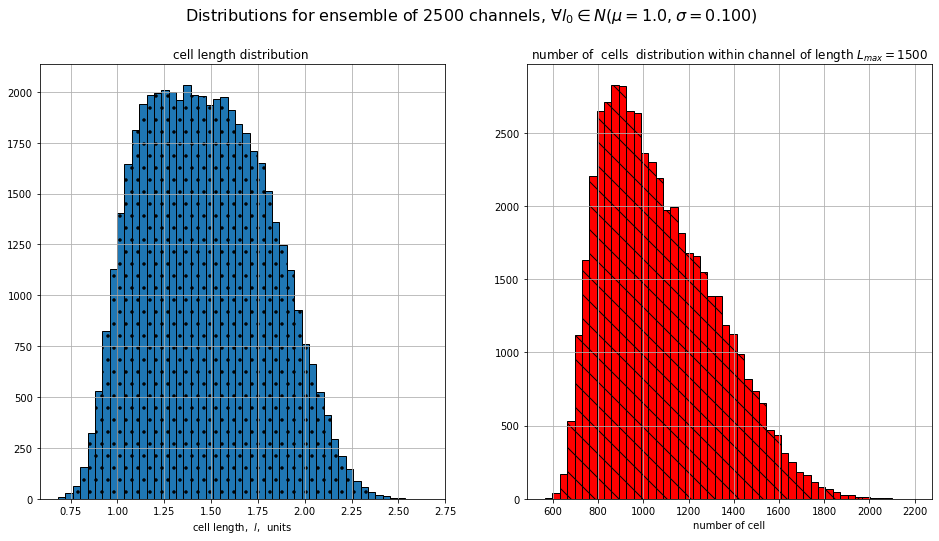

In [32]:
plot_hists()
plot_hists(sigma=0.05)
plot_hists(sigma=0.1)

# Real lab  experiment data analysis


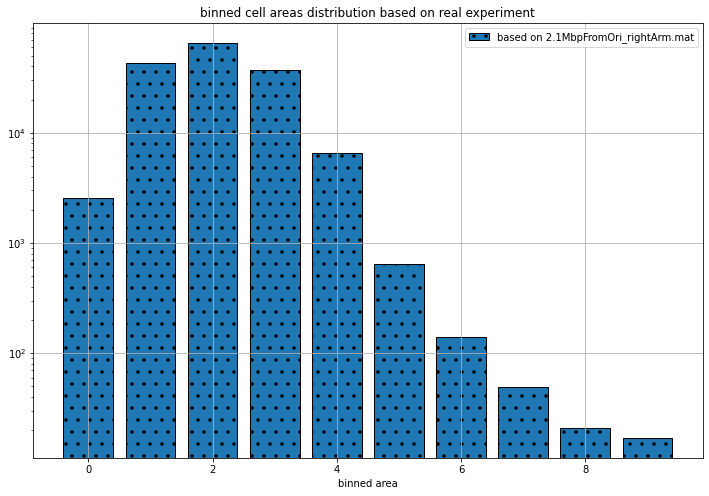

In [54]:
lab_experiment_area_bin_hist = [(0,2581),
(1,    43056),
(2,    65665),
(3,    37202),
(4,     6586),
(5,      649),
(6,      141),
(7,       49),
(8,       21),
(9,       17)]

x,y = zip(*lab_experiment_area_bin_hist)
plt.figure(figsize=(12,8))
plt.title("binned cell areas distribution based on real experiment")
plt.xlabel("binned area")
plt.bar(x,y, label='based on 2.1MbpFromOri_rightArm.mat', hatch='.', edgecolor='black')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

One can see a smooth curve.  The bin numbers around 5-7 correspond to the cell areas right before the division process. That can be supported by looking at  the  fork plots: two maxima at $1/4$ and $3/4$ of the long axis.



# Conclusions

In all observed regimes (diffent $\sigma$) the cell size distribution plots show that the region $[1.0:2.0]$ in length units is decently populated. The difference does not exceed one order  of magnitude.

The  shape of number of  cells distributions also embraces the region from $L_{max}/2$ -- largest cell size just before division to  $L_{max}$ -- the number of newly born cells of $l_0$ length.


Besed on the observed in the real lab experiment, the correlation between  length and area of the  cell, one can expect  see for area the similar curves as above.

Some corrections should  be put  due to the real cell grows  process is not ideal, as assumed here.

One could perhaps ask why the population of cell falls so fast for larger area bin numbers?
For the simulation the difference does not  exceed 10  times, while for the real lab experiment the population difference between newly borned  cells (area  bin =2) and  cell right  before  division (area bin 5-7) more than 2 orders of magnitude, forcing to conduct a large  number of additional experiments to read decent statistical quality for the data.